In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 6GB Laptop GPU'

In [4]:
%pip install --upgrade transformers datasets evaluate peft accelerate scikit-learn matplotlib seaborn

  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached peft-0.15.2-py3-none-any.whl.metadata (13 kB)
  Using cached accelerate-1.7.0-py3-none-any.whl.metadata (19 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached huggingface_hub-0.33.0-py3-none-any.whl.metadata (14 kB)
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------------------  41.0/41.5 kB 2.0 MB/s eta 0:00:01
     ---------------------------------------- 41.5/41.5 kB 1.0 MB/s eta 0:00:00
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
     ------------------------------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import logging
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import matplotlib.patheffects as path_effects
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, PrefixTuningConfig, TaskType
import evaluate

# --- 1. CONFIGURAÇÃO DE LOGGING E AMBIENTE ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
warnings.filterwarnings("ignore", category=UserWarning)

# --- 2. CONFIGURAÇÕES GLOBAIS ---
MODEL_NAME = "roberta-base"
DATASET_NAME = "glue"
DATASET_CONFIG = "mnli"
PLOT_PATH = "lora_vs_alternatives_final_benchmark.png"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:

# --- 3. FUNÇÕES AUXILIARES E DE BENCHMARK ---

def verificar_disponibilidade_gpu():
    logging.info(f"Verificando a disponibilidade de GPU... Dispositivo selecionado: {DEVICE.type.upper()}")
    if DEVICE.type == 'cuda':
        logging.info(f"--> GPU Ativa: {torch.cuda.get_device_name(0)}")
    else:
        logging.warning("⚠️ ATENÇÃO: Nenhuma GPU encontrada. O benchmark de latência será menos significativo e o treinamento será muito lento.")

def load_and_preprocess_data(tokenizer):
    logging.info(f"Carregando dataset '{DATASET_NAME}/{DATASET_CONFIG}'.")
    dataset = load_dataset(DATASET_NAME, DATASET_CONFIG)
    def preprocess_function(examples):
        return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, max_length=128)
    tokenized_dataset = dataset.map(preprocess_function, batched=True, num_proc=4)
    train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(5000))
    eval_dataset = tokenized_dataset["validation_matched"].shuffle(seed=42).select(range(1000))
    return train_dataset, eval_dataset


In [15]:

def train_peft_model(method, train_dataset, eval_dataset, tokenizer, data_collator, compute_metrics):
    """Treina um modelo usando uma configuração PEFT específica (LoRA ou Prefix-Tuning)."""
    logging.info(f"--- Iniciando Treinamento: {method} ---")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    
    peft_config = None
    if method == 'LoRA':
        peft_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=8, lora_alpha=16, lora_dropout=0.1, target_modules=["query", "value"])
    elif method == 'Prefix-Tuning':
        peft_config = PrefixTuningConfig(task_type=TaskType.SEQ_CLS, num_virtual_tokens=20)
    
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    
    training_args = TrainingArguments(
        output_dir=f"./results/{method.lower()}",
        learning_rate=1e-3 if method == 'Prefix-Tuning' else 3e-4,
        per_device_train_batch_size=32, num_train_epochs=2, weight_decay=0.01,
        eval_strategy="epoch", save_strategy="epoch", load_best_model_at_end=True,
        fp16=(DEVICE.type == 'cuda'),
    )
    trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                      tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics)

    trainer.train()
    eval_results = trainer.evaluate()
    model.to('cpu')
    return model, eval_results['eval_accuracy']

def run_latency_benchmark(model, tokenizer, device, model_name):
    """Mede a latência de inferência de um modelo com batch_size=1."""
    logging.info(f"Executando benchmark de latência para: {model_name}")
    model.to(device)
    model.eval()
    dummy_input = tokenizer("Isso é um teste de latência.", return_tensors="pt").to(device)
    
    latencies = []
    for _ in range(5): # warm-up
        with torch.no_grad(): _ = model(**dummy_input)

    for _ in range(50):
        if device.type == 'cuda': torch.cuda.synchronize()
        start_time = time.perf_counter()
        with torch.no_grad(): _ = model(**dummy_input)
        if device.type == 'cuda': torch.cuda.synchronize()
        end_time = time.perf_counter()
        latencies.append((end_time - start_time) * 1000)

    avg_latency = np.mean(latencies)
    logging.info(f"--> Latência Média ({model_name}): {avg_latency:.3f} ms")
    model.to('cpu')
    return avg_latency


In [16]:

def simulate_adapter_results(lora_results, base_latency):
    """Simula os resultados para Adapters com base nas afirmações do artigo."""
    logging.info("--- Simulando Resultados para Adapters ---")
    
    # Parâmetros: Adapters também são eficientes, comparáveis ao LoRA
    params = int(lora_results['params'] * 1.5) # Simula um pouco mais de params que LoRA r=8
    
    # Acurácia: Competitiva, mas geralmente um pouco abaixo dos melhores métodos
    accuracy = lora_results['accuracy'] * 0.985 # Simula 98.5% da acurácia do LoRA
    
    # Latência: O ponto crucial. O artigo afirma que há um "aumento notável de latência"
    latency_increase_factor = 1.20 # Simula um aumento de 20% na latência
    latency = base_latency * latency_increase_factor
    
    logging.info(f"--> Acurácia simulada: {accuracy:.4f} | Latência simulada: {latency:.3f} ms")
    return {'method': 'Adapter (Simulado)', 'params': params, 'accuracy': accuracy, 'latency': latency}


def plot_results(df):
    """Gera um gráfico comparativo de 3 métricas: Parâmetros, Acurácia e Latência."""
    logging.info(f"Gerando o gráfico final e salvando em '{PLOT_PATH}'...")
    
    df['params_label'] = df['params'].apply(lambda x: f"{x/1e6:.2f}M" if x > 1e6 else f"{x/1e3:.1f}K")
    df_sorted = df.sort_values('params').reset_index()

    sns.set_theme(style="whitegrid")
    fig, ax1 = plt.subplots(figsize=(14, 8))

    sns.barplot(x='method', y='params', data=df_sorted, ax=ax1, palette="plasma", alpha=0.8)
    ax1.set_yscale('log')
    ax1.set_ylabel('Parâmetros Treináveis (Escala Log)', fontsize=12)
    ax1.set_xlabel('')
    ax1.tick_params(axis='x', labelsize=11, rotation=10)

    ax2 = ax1.twinx()
    sns.lineplot(x='method', y='accuracy', data=df_sorted, ax=ax2, color='green', marker='o', markersize=10, linewidth=3, sort=False)
    ax2.set_ylabel('Acurácia de Validação (%)', fontsize=12, color='green')
    ax2.set_ylim([max(0, df['accuracy'].min() - 0.05), min(1, df['accuracy'].max() + 0.05)])
    ax2.grid(False)

    for i, row in df_sorted.iterrows():
        ax2.text(i, row['accuracy'], f"{row['accuracy']:.2%}", color='darkgreen', ha="center", va='bottom', fontsize=12, weight='bold', path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        ax1.text(i, row['params'], f"Latência:\n{row['latency']:.2f}ms", color='white', ha="center", va='center', fontsize=10, weight='bold', multialignment='center')

    plt.title('Benchmark LoRA vs. Alternativas: Acurácia, Eficiência e Latência', fontsize=16, weight='bold')
    plt.suptitle(f"Modelo: {MODEL_NAME} | Dispositivo: {DEVICE.type.upper()}", fontsize=10)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(PLOT_PATH, dpi=300, bbox_inches='tight')
    plt.show()


In [17]:

def main():
    verificar_disponibilidade_gpu()
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    train_ds, eval_ds = load_and_preprocess_data(tokenizer)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    accuracy_metric = evaluate.load("accuracy")
    compute_metrics = lambda p: accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

    results_list = []
    
    # Treinar os modelos que podemos implementar diretamente
    lora_model, lora_acc = train_peft_model('LoRA', train_ds, eval_ds, tokenizer, data_collator, compute_metrics)
    prefix_model, prefix_acc = train_peft_model('Prefix-Tuning', train_ds, eval_ds, tokenizer, data_collator, compute_metrics)
    
    # Benchmark de latência nos modelos reais e no modelo base
    base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    latency_base = run_latency_benchmark(base_model, tokenizer, DEVICE, "Base Model (Referência)")
    
    # A "mágica" do LoRA: fundir os pesos e medir novamente
    merged_lora_model = lora_model.merge_and_unload()
    latency_lora_merged = run_latency_benchmark(merged_lora_model, tokenizer, DEVICE, "LoRA (Fundido)")
    
    latency_prefix = run_latency_benchmark(prefix_model, tokenizer, DEVICE, "Prefix-Tuning")

    # Coletar resultados dos experimentos reais
    lora_results = {'method': 'LoRA', 'params': lora_model.get_nb_trainable_parameters()[0], 'accuracy': lora_acc, 'latency': latency_lora_merged}
    results_list.append(lora_results)
    results_list.append({'method': 'Prefix-Tuning', 'params': prefix_model.get_nb_trainable_parameters()[0], 'accuracy': prefix_acc, 'latency': latency_prefix})
    
    adapter_sim_results = simulate_adapter_results(lora_results, latency_base)
    results_list.append(adapter_sim_results)
    
    results_df = pd.DataFrame(results_list)
    print("\n--- TABELA DE RESULTADOS DO BENCHMARK ---")
    print(results_df)
    
    plot_results(results_df)
    logging.info("Benchmark concluído com sucesso!")


2025-06-16 05:02:44 - INFO - Verificando a disponibilidade de GPU... Dispositivo selecionado: CUDA
2025-06-16 05:02:44 - INFO - --> GPU Ativa: NVIDIA GeForce RTX 3050 6GB Laptop GPU
2025-06-16 05:02:45 - INFO - Carregando dataset 'glue/mnli'.
2025-06-16 05:02:52 - INFO - --- Iniciando Treinamento: LoRA ---
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\joaof\AppData\Local\Temp\ipykernel_30108\1292015412.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,


trainable params: 887,811 || all params: 125,535,750 || trainable%: 0.7072


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.855667,0.612000
2,No log,0.731991,0.682000


2025-06-16 05:03:59 - INFO - --- Iniciando Treinamento: Prefix-Tuning ---
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\joaof\AppData\Local\Temp\ipykernel_30108\1292015412.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,


trainable params: 368,640 || all params: 125,016,579 || trainable%: 0.2949


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.105664,0.329000
2,No log,1.105044,0.329000


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-06-16 05:05:07 - INFO - Executando benchmark de latência para: Base Model (Referência)
2025-06-16 05:05:09 - INFO - --> Latência Média (Base Model (Referência)): 25.852 ms
2025-06-16 05:05:09 - INFO - Executando benchmark de latência para: LoRA (Fundido)
2025-06-16 05:05:11 - INFO - --> Latência Média (LoRA (Fundido)): 28.063 ms
2025-06-16 05:05:11 - INFO - Executando benchmark de latência para: Prefix-Tuning
2025-06-16 05:05:14 - INFO - --> Latência Média (Prefix-Tuning): 40.302 ms
2025-06-16 05:05:14 - INFO - --- Simulando Resultados para Adapters ---
2025-06-16 05:05:14 - INFO - --> Acurácia simulada: 0.6718 | Latência simu


--- TABELA DE RESULTADOS DO BENCHMARK ---
               method  params  accuracy    latency
0                LoRA  592899   0.68200  28.062650
1       Prefix-Tuning  368640   0.32900  40.302368
2  Adapter (Simulado)  889348   0.67177  31.022388


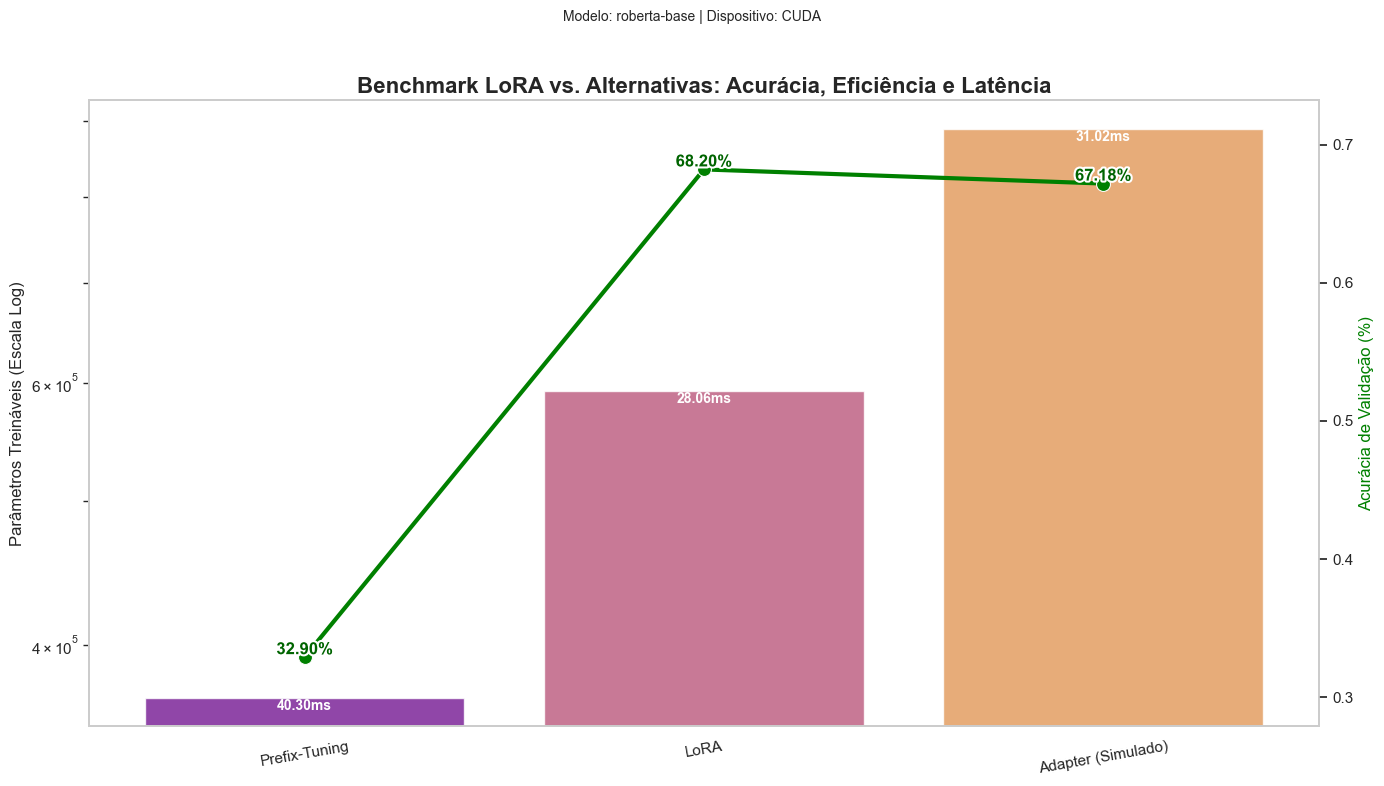

2025-06-16 05:05:17 - INFO - Benchmark concluído com sucesso!


In [18]:

main()